In [81]:
library(keras)
library(dplyr) 
use_condaenv('r-tensorflow')

The function get.scale returns a list with two parameters : first the mean, second the std. If the input is already centered (it has an attribute center which is taken up by attr), we extract the mean. If it's not, we put the mean by default at 0. If the input is already scale (it has an attribute scale), we extract the std, if it's not we put the std by default at 1.
The function scale.as enables to scale a data set X2 the same way X1 was scaled

In [82]:
get.scale <- function(scaled) {
  if ("scaled:center" %in% names(attributes(scaled))) {
      center <- attr(scaled, "scaled:center")
  } else {
      center <- rep(0, ncol(scaled))
  }
  if ("scaled:scale" %in% names(attributes(scaled))) {
      list(center, attr(scaled, "scaled:scale"))
  } else {
      list(center, rep(1., length(center)))
  }
}
scale.as.x <- function(x, scaled) {
  s <- get.scale(scaled)
  centered <- sweep(x, 2, s[[1]])
  sweep(centered, 2, s[[2]], FUN = "/")
}

scale.as.y <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}

unscale.y <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}

In [168]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))


In [ ]:
#searching for input variables with zero variance (without the varible Intensity)
x = train.data[, -c(2,3)]
y = train.data$VALENCE.PLEASANTNESS
x$Intensity <- as.numeric(train.data$Intensity)
idx.zero.var <- apply(x, 2, var) == 0
#x is the whole training data (only predictors)
x <- x[,!idx.zero.var]


test.x <- test.data[,-c(1,2)]

test.x$Intensity <- as.numeric(test.data$Intensity)
test.x <- test.x[,!idx.zero.var]

full.data = data.frame(x,y)

In [220]:
#Split the data between a training and a test set
set.seed(100)
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- x[idx.train,]
train.y <- y[idx.train]
validation.x <- x[-idx.train,]
validation.y <- y[-idx.train]


train.x.prep <- scale(train.x, center = T, scale = T)
train.y.prep <- scale(train.y, center = T, scale = T)

validation.x.scaled = scale.as.x(validation.x,train.x.prep)
validation.y.scaled = scale.as.y(validation.y,train.y.prep)
#We have 472 rows in the training set, and 472 for the test set
#Training data is scaled 


test.x.scaled = scale.as.x(test.x,train.x.prep)


complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,...,Depressant.50,Psychotic.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50,Intensity
59.93038,0.49658659,-3.070169,1.54589299,1.85295193,-1.0210587,2.1272149,-2.665274,6.740141,-15.59330,...,-0.2101286,-0.06516367,-0.2362412,-0.04602873,-0.481543,-0.1392741,-0.4063024,-0.07989391,-0.6685087,10.80519
388.68795,0.43672528,-3.031279,1.53111766,0.94196547,-1.3180512,0.8907758,-2.648885,7.556857,-13.13540,...,-0.2101286,-0.06516367,-0.2362412,-0.04602873,-0.481543,-0.1392741,-0.4063024,-0.07989391,-0.6685087,10.80519
154.86038,0.20899516,-3.096044,1.56152075,2.19222832,-1.1903151,2.4482174,-2.667452,7.131484,-19.80009,...,-0.2101286,-0.06516367,-0.2362412,-0.04602873,-0.481543,-0.1392741,-0.4063024,-0.07989391,-0.6685087,10.80519
187.23650,0.69560043,-3.091500,2.64466653,3.22135163,-0.6643502,3.5065702,-2.663096,6.876261,-17.38946,...,-0.2101286,-0.06516367,-0.2362412,21.67953225,-0.481543,-0.1392741,-0.4063024,12.49008081,-0.6685087,10.80519
93.10592,-0.22003467,-3.104603,0.92476061,1.24103466,-1.4609300,1.5081822,-2.668179,6.910290,-19.61102,...,-0.2101286,-0.06516367,-0.2362412,-0.04602873,-0.481543,-0.1392741,-0.4063024,-0.07989391,-0.6685087,10.80519
270.77490,0.69488609,-3.069993,2.26420163,2.44431383,-0.9170136,2.5671449,-2.659050,7.216559,-16.53865,...,-0.2101286,-0.06516367,-0.2362412,21.67953225,-0.481543,-0.1392741,-0.4063024,12.49008081,-0.6685087,10.80519
147.46583,0.07998619,-3.029977,0.45393884,0.30474930,-1.7266601,0.3660719,-2.661229,7.846111,-17.15312,...,-0.2101286,-0.06516367,-0.2362412,-0.04602873,-0.481543,-0.1392741,-0.4063024,-0.07989391,-0.6685087,10.80519
238.79848,1.01076520,-3.103478,3.29677030,4.79756376,-0.3299894,5.2254278,-2.668075,6.944320,-19.61102,...,-0.2101286,-0.06516367,-0.2362412,21.67953225,-0.481543,7.1648763,-0.4063024,12.49008081,-0.6685087,10.80519
82.71358,-0.57863103,-3.055301,-0.31722003,-0.58974770,-2.1429625,-0.5152111,-2.665067,8.135364,-21.31265,...,-0.2101286,-0.06516367,-0.2362412,-0.04602873,-0.481543,-0.1392741,-0.4063024,-0.07989391,-0.6685087,10.80519
462.63342,1.15348941,-3.093552,3.43145317,4.59810900,-0.3008030,4.9377656,-2.665067,6.995365,-18.47661,...,-0.2101286,-0.06516367,-0.2362412,21.67953225,-0.481543,7.1648763,-0.4063024,12.49008081,-0.6685087,10.80519


In [212]:
set.seed(100)
nn <- keras_model_sequential()
nn <- nn %>%
      layer_dense(units = 100, activation = 'relu', input_shape = c(dim(train.x)[2]),
                  kernel_regularizer = regularizer_l2(l = 0.001)) %>%
      layer_dropout(rate=0.4)%>%
      layer_dense(units = 100, activation = 'relu') %>%
      layer_dropout(rate=0.4)%>%
      layer_dense(units = 100, activation = 'relu') %>%
      layer_dropout(rate=0.4)%>%
      layer_dense(units = 1, activation = 'linear')

In [213]:
nn %>% compile(optimizer = "adam", loss = "mean_squared_error", metrics = list("mean_absolute_error"))

In [214]:
set.seed(100)
history <- nn %>% fit(as.matrix(train.x.prep),
                      as.matrix(train.y.prep),
                      verbose = 0,
                      batch_size = 128,
                      validation_data = list(as.matrix(validation.x.scaled),as.matrix(validation.y.scaled)),
                      epochs = 100)


`geom_smooth()` using formula 'y ~ x'


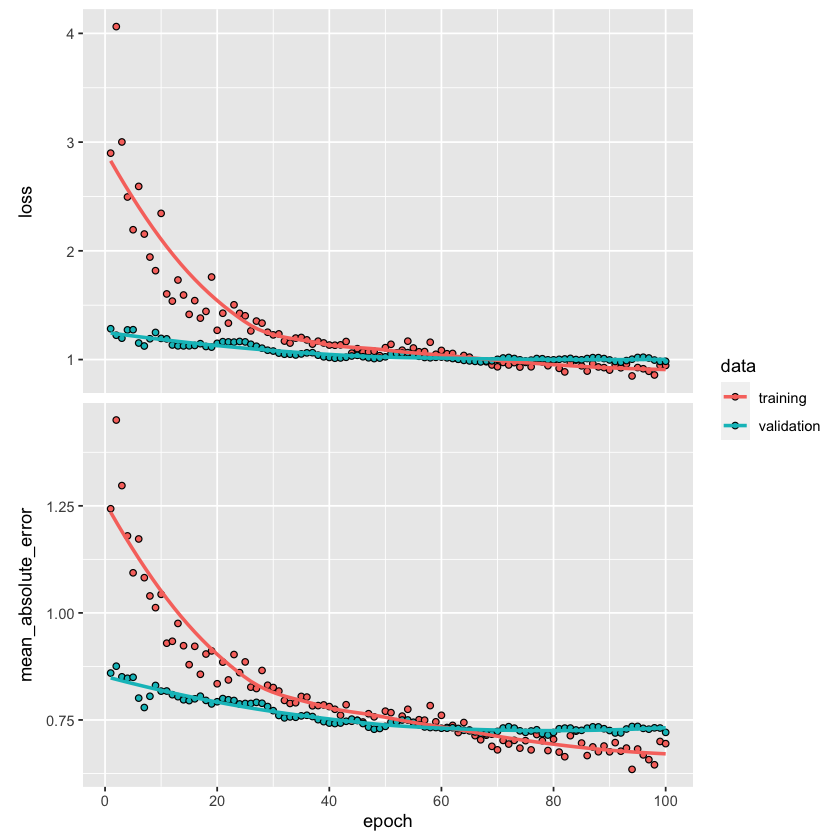

In [215]:
plot(history)

In [218]:
nn.pred <- predict(nn, as.matrix(validation.x.scaled))
nn.pred.unscaled = unscale.y(nn.pred, train.y.prep)

sqrt(mean((nn.pred.unscaled - validation.y)^2))

[1] 20.9372

In [ ]:
prediction <- predict(nn, as.matrix(test.x.scaled))
prediction